# Import

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time

# Model

In [2]:
def make_generator_model():

    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*128, use_bias=False, input_shape=(DIM_NOISE,)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((7, 7, 128)))

    model.add(layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(filters=1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model


def make_critic_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


@tf.function
def get_gradient_penalty(real_snaps_batch, fake_snaps_batch):

    EPSILON = tf.random.uniform(
        shape=[real_snaps_batch.shape[0], 1, 1, 1],
        minval=0,
        maxval=1,
        dtype=tf_dtype)
    interpolation = EPSILON * real_snaps_batch + (1 - EPSILON) * fake_snaps_batch
    
    with tf.GradientTape() as tapeGP:
        tapeGP.watch(interpolation)
        critic_interpolation = critic(interpolation)
    gradients = tapeGP.gradient(critic_interpolation, interpolation)
    
    norm_gradients = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis = [1, 2, 3]))
    gp = tf.reduce_mean(tf.square(norm_gradients - 1))
    
    return gp


@tf.function
def train_step(real_snaps_batch):
    for i in range (CRITIC_ITERS):
        with tf.GradientTape() as tapeD:
            noise = tf.random.normal([real_snaps_batch.shape[0], DIM_NOISE])
            fake_snaps_batch = generator(noise, training=True)
            
            logits_fake = critic(fake_snaps_batch, training=True)
            logits_real = critic(real_snaps_batch, training=True)
            
            Wasserstein_distance = tf.reduce_mean(logits_real) - tf.reduce_mean(logits_fake)
            gradient_penalty = get_gradient_penalty(real_snaps_batch, fake_snaps_batch)
            critic_loss = - Wasserstein_distance + LAMBDA * gradient_penalty

        critic_grads_list = tapeD.gradient(critic_loss, critic.trainable_variables)
        critic_optimizer.apply_gradients(zip(critic_grads_list, critic.trainable_variables))
    
    for i in range (GENERATOR_ITERS):
        with tf.GradientTape() as tapeG:
            noise = tf.random.normal([real_snaps_batch.shape[0], DIM_NOISE])
            fake_snaps_batch = generator(noise, training=True)
            
            logits_fake = critic(fake_snaps_batch, training=True)
            
            generator_loss = - tf.reduce_mean(logits_fake)

        generator_grads_list = tapeG.gradient(generator_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(generator_grads_list, generator.trainable_variables))

    return Wasserstein_distance, gradient_penalty, critic_loss, generator_loss


def train(train_dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for real_snaps_batch in train_dataset:
            Wasserstein_distance, gradient_penalty, critic_loss, generator_loss = train_step(real_snaps_batch)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

        list_Wasserstein_distance.append(Wasserstein_distance)
        list_gradient_penalty.append(gradient_penalty)
        list_critic_loss.append(critic_loss)
        list_generator_loss.append(generator_loss)


# Hyperparameters

In [3]:
tf_dtype = tf.float32
NUM_SNAPS = 320
BATCH_SIZE = 32
EPOCHS = 2000
DIM_NOISE = 4
LAMBDA = 10
CRITIC_ITERS = 1
GENERATOR_ITERS = 2
LEARNING_RATE_CRITIC = 0.0003
LEARNING_RATE_GENERATOR = 0.0001

# Process the training data

In [4]:
(images, labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = images[: NUM_SNAPS].reshape(NUM_SNAPS, images.shape[1], images.shape[2], 1)
train_images = (train_images - 127.5) / 127.5
train_images = tf.convert_to_tensor(train_images, dtype=tf_dtype)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(NUM_SNAPS).batch(BATCH_SIZE)

# Training

In [5]:
list_Wasserstein_distance = []
list_gradient_penalty = []
list_critic_loss = []
list_generator_loss = []

In [6]:
generator = make_generator_model()
critic = make_critic_model()

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_GENERATOR, beta_1=0.5, beta_2=0.9)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_CRITIC, beta_1=0.5, beta_2=0.9)

train(train_dataset, EPOCHS)

2024-02-29 17:55:27.661127: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Time for epoch 1 is 1.2270281314849854 sec
Time for epoch 2 is 0.7009861469268799 sec
Time for epoch 3 is 0.7421920299530029 sec
Time for epoch 4 is 0.821584939956665 sec
Time for epoch 5 is 0.7682430744171143 sec
Time for epoch 6 is 0.8058209419250488 sec
Time for epoch 7 is 0.7687170505523682 sec
Time for epoch 8 is 0.8775160312652588 sec
Time for epoch 9 is 0.7827656269073486 sec
Time for epoch 10 is 0.8178360462188721 sec
Time for epoch 11 is 0.7661218643188477 sec
Time for epoch 12 is 0.7544369697570801 sec
Time for epoch 13 is 0.8856868743896484 sec
Time for epoch 14 is 0.8732399940490723 sec
Time for epoch 15 is 0.8651609420776367 sec
Time for epoch 16 is 0.7753021717071533 sec
Time for epoch 17 is 0.7829501628875732 sec
Time for epoch 18 is 0.7752809524536133 sec
Time for epoch 19 is 0.7741069793701172 sec
Time for epoch 20 is 0.7642307281494141 sec
Time for epoch 21 is 0.7868218421936035 sec
Time for epoch 22 is 0.771806001663208 sec
Time for epoch 23 is 0.7891228199005127 sec

# Results

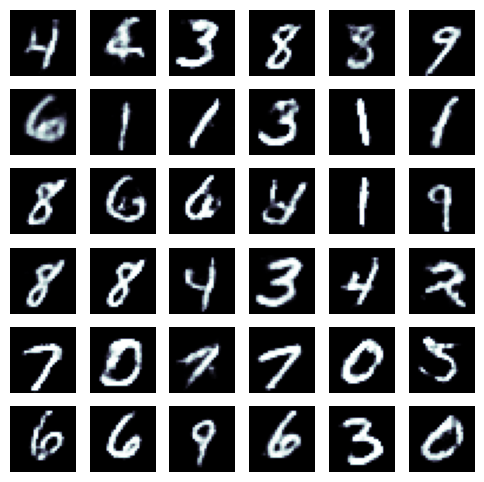

In [7]:
noise = tf.random.normal([36, DIM_NOISE])
predictions = generator(noise, training=False)
    
fig = plt.figure(figsize=(6, 6))
    
for i in range(predictions.shape[0]):
    plt.subplot(6, 6, i + 1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap=plt.cm.bone)
    plt.axis('off')

plt.show()

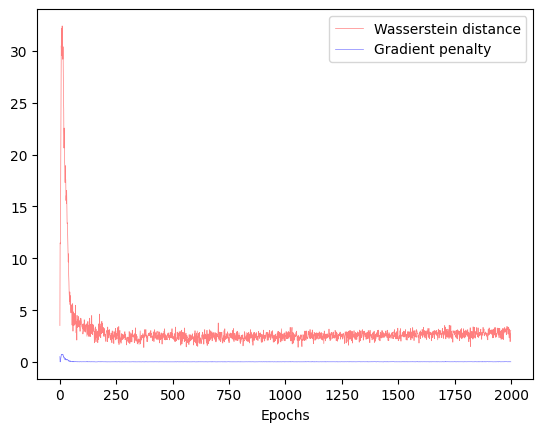

In [8]:
plt.figure()
plt.xlabel('Epochs')
plt.plot(list_Wasserstein_distance, 
         linewidth=0.5, c = 'r', alpha=0.5, label='Wasserstein distance')
plt.plot(list_gradient_penalty,
         linewidth=0.5, c='b', alpha=0.5, label='Gradient penalty')

plt.legend()

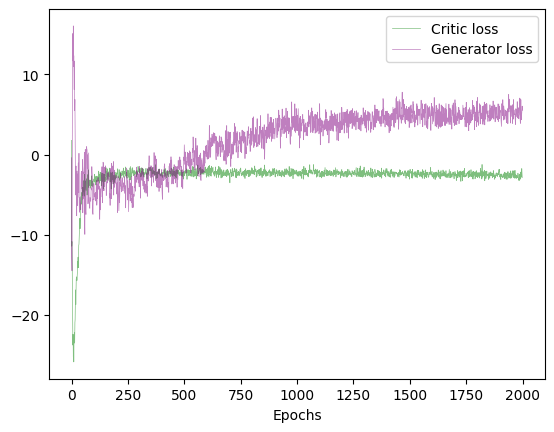

In [9]:
plt.figure()
plt.xlabel('Epochs')
plt.plot(list_critic_loss,
         linewidth=0.5, c='green', alpha=0.5, label='Critic loss')
plt.plot(list_generator_loss,
         linewidth=0.5, c='purple', alpha=0.5, label='Generator loss')

plt.legend()